In [1]:
import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=UserWarning)
warnings.filterwarnings('ignore',category=ImportWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from scipy.stats import randint, loguniform
from imblearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import LeaveOneOutEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import RFE
from imblearn.over_sampling import ADASYN
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, PowerTransformer, QuantileTransformer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

In [2]:
# List of continuous features to be binned into intervals
ordinal_features = ['week','qtr']
binned_features = ['play_sequence_game','game_seconds_remaining','half_seconds_remaining']

bin_discretizer_strategy = ['quantile','kmeans','uniform']        # KBinsDiscretizer strategy: uniform, quantile, kmeans
bin_discretizer_encode = ['ordinal']                              # KBinsDiscretizer encode: ordinal, onehot, onehot-dense

# Train test split parameters
test_holdout_percentage = 0.10

# RFE feature selection
rfc_est = 150                     # random_forest_classifier_n_estimators
rfc_max = 'sqrt'                  # random_forest_classifier_max_features

# Define list of scalers being used
scaler_list = [StandardScaler(), 
               RobustScaler(), 
               MinMaxScaler(), 
               MaxAbsScaler(), 
               PowerTransformer(),
               QuantileTransformer(output_distribution='normal'), 
               QuantileTransformer(output_distribution='uniform'),
               ]

# Specify the HalvingRandomSearchCV parameters
scoring = 'accuracy'                        
n_cross_validation = 3
halving_parameter = 5.0
max_resource = 2000
resource_divisor = 5.0
min_resource = int(round((max_resource / resource_divisor), 0))

In [3]:
# Create timer to calculate total workbook time in hours
start_time = time.time()

## IMPORT PROCESSED NFL-DATA-PY CSV FILE
##### https://pypi.org/project/nfl-data-py/

In [4]:
# Import csv file from nfl-data-py
df = pd.read_csv(r'/Users/ttas2/Documents/Python/nfl-machine-learning-models/output_files/nfl_post_processing_run_pass_classification_data.csv')

df.shape

(67243, 128)

In [5]:
# Print list of columns
print(df.columns.to_list())

['week', 'half_seconds_remaining', 'game_seconds_remaining', 'qtr', 'goal_to_go', 'ydstogo', 'play_type', 'shotgun', 'no_huddle', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'posteam_score', 'defteam_score', 'no_score_prob', 'safety_prob', 'ep', 'wp', 'total_line', 'div_game', 'defenders_in_box', 'report_eligible', 'wr_to_db_ratio', 'ol_to_dl_ratio', 'play_sequence_game', 'play_sequence_series', 'score_differential_norm', 'dtg_99to96', 'dtg_95to90', 'dtg_89to75', 'dtg_74to55', 'dtg_54to45', 'dtg_34to21', 'dtg_20to10', 'dtg_09to00', 'prev1_big_play_pass', 'prev3_big_play_pass', 'prev1_big_play_run', 'prev2_big_play_run', 'prev3_big_play_run', 'prev1_negative_pass', 'prev2_negative_pass', 'prev1_negative_run', 'prev2_negative_run', 'prev3_negative_run', 'prev1_play_off_penalty', 'prev1_play_def_penalty', 'prev2_play_off_penalty', 'prev3_play_def_penalty', 'prev1_play_run_outside', 'prev1_play_run_inside', 'prev1_play_pass_deep', 'prev1_play_pass_short', 'prev2_play_run_ou

In [6]:
# Identify columns in bin_discretizer_strategy or bin_discretizer_encode that are not in the dataframe
print(set(ordinal_features) - set(df.columns))
print(set(binned_features) - set(df.columns))

set()
set()


In [7]:
# Convert binary columns to integers
binary_columns = df.columns[df.isin([0,1]).all()].tolist()
df[binary_columns] = df[binary_columns].apply(pd.to_numeric, downcast='integer', errors='coerce', axis=1)

In [8]:
# Print columns with missing values
print(df.columns[df.isnull().any()].tolist())

[]


In [9]:
# Target frequency
target_count = df.play_type.value_counts(normalize=True)

target_count

play_type
1    0.597475
0    0.402525
Name: proportion, dtype: float64

## TRAIN TEST SPLIT
##### https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [10]:
# split data into target and feature datasets
X, y = df.loc[:, df.columns != 'play_type'], df['play_type']

initial_features = X.columns.to_list()

# Create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_holdout_percentage, random_state=67)


## BASELINE MODEL
##### https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [11]:
# Create and fit baseline model to compare performance
baseline_model = DummyClassifier(strategy='most_frequent', random_state=67)
baseline_model.fit(X_train, y_train)

# Calculate model accuracy on test data
y_baseline_pred = baseline_model.predict(X_test)

print(f"Baseline accuracy: {round(accuracy_score(y_test,y_baseline_pred)*100, 1)}%")


Baseline accuracy: 58.3%


## MODEL PIPELINE
##### https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
##### https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
##### https://imbalanced-learn.org/stable/references/over_sampling.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
##### https://xgboost.readthedocs.io/en/stable/parameter.html

In [12]:
# Create feature type lists for column transform stage of the pipeline
categorical_features = list(X_train.select_dtypes(include='object'))
boolean_features = X_train.columns[X_train.isin([0, 1]).all()].tolist()
numeric_features = list(set(X_train.columns) - set(ordinal_features) - set(categorical_features) - set(boolean_features) - set(binned_features))

print('Total features:', len(initial_features))
print(' ')
print('Boolean features:', len(boolean_features)) #, ':', boolean_features)
print('Numeric features:', len(numeric_features), ':', numeric_features)
print('Ordinal features:', len(ordinal_features), ':', ordinal_features)
print('Binned features:', len(binned_features), ':', binned_features)
print('Categorical features:', len(categorical_features), ':', categorical_features)

Total features: 127
 
Boolean features: 69
Numeric features: 32 : ['prev1_wpa', 'score_differential_norm', 'prev1_yards_gained', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'ep', 'remaining_downs', 'prev4_yards_gained', 'wr_to_db_ratio', 'run_ratio_def_priors', 'prev3_yards_gained', 'game_temp_div_game_humidity', 'ep_game_sec_ratio', 'prev5_yards_gained', 'play_sequence_series', 'prev5_wpa', 'ol_to_dl_ratio', 'ydstogo', 'defenders_in_box', 'posteam_score', 'prev3_wpa', 'prev2_yards_gained', 'safety_prob', 'remaining_yards_per_down', 'no_score_prob', 'run_ratio_off_priors', 'total_line', 'prev2_wpa', 'wp', 'prev4_wpa', 'defteam_score', 'ep_half_sec_ratio']
Ordinal features: 2 : ['week', 'qtr']
Binned features: 3 : ['play_sequence_game', 'game_seconds_remaining', 'half_seconds_remaining']
Categorical features: 21 : ['posteam', 'posteam_type', 'defteam', 'roof', 'surface', 'offense_formation', 'offense_personnel', 'defense_personnel', 'game_weather', 'play_type_prev1', 'pl

In [13]:
# Custom transformer for IQR outlier exclusion
class IQRTransformer:
    def __init__(self, numerical_cols):
        self.numerical_cols = numerical_cols
        self.lower_bound = None
        self.upper_bound = None

    def fit(self, x):
        if isinstance(x, pd.DataFrame):
            # Calculate the IQR for each numerical column
            q1 = x[self.numerical_cols].quantile(0.25)
            q3 = x[self.numerical_cols].quantile(0.75)
            iqr = q3 - q1

            # Define the lower and upper bounds for outliers
            self.lower_bound = (q1 - 1.5 * iqr).to_dict()
            self.upper_bound = (q3 + 1.5 * iqr).to_dict()
        else:
            # Calculate the IQR for each numerical column
            q1 = np.quantile(x[:, :], 0.25, axis=0)
            q3 = np.quantile(x[:, :], 0.75, axis=0)
            iqr = q3 - q1

            # Define the lower and upper bounds for outliers
            self.lower_bound = (q1 - 1.5 * iqr).tolist()
            self.upper_bound = (q3 + 1.5 * iqr).tolist()

        return self

    def transform(self, x):
        if isinstance(x, pd.DataFrame):
            # Exclude outliers based on the IQR for each numerical column
            x_outlier_removed = x.copy()
            for col in self.numerical_cols:
                if col in self.lower_bound and col in self.upper_bound:
                    x_outlier_removed = x_outlier_removed[
                        (x_outlier_removed[col] >= self.lower_bound[col]) & (x_outlier_removed[col] <= self.upper_bound[col])
                    ].dropna()
        else:
            # Exclude outliers based on the IQR for each numerical column
            x_outlier_removed = x.copy()
            for i, col in enumerate(self.numerical_cols):
                if col in self.lower_bound and col in self.upper_bound:
                    lower_bound = self.lower_bound[col]
                    upper_bound = self.upper_bound[col]
                    x_outlier_removed = x_outlier_removed[
                        (x_outlier_removed[:, i] >= lower_bound) & (x_outlier_removed[:, i] <= upper_bound)
                    ].dropna()

        return x_outlier_removed

In [14]:
# Create custom transformer for selecting a feature scaler: StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
class ScalerSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, scaler=StandardScaler()):
        super().__init__()
        self.scaler = scaler

    def fit(self, x):
        return self.scaler.fit(x)

    def transform(self, x):
        return self.scaler.transform(x)
    
# scaler and encoder options
feature_scaler = ScalerSelector()

In [15]:
# Specify the transformations per data type
num_trans = Pipeline(steps=[('num_imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                            ('num_outlier', IQRTransformer(numerical_cols=numeric_features)),
                            ('num_scaler', feature_scaler),
                           ])

cat_trans = Pipeline(steps=[('cat_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                            ('cat_encoder', LeaveOneOutEncoder(handle_missing='value', handle_unknown='value', random_state=67)),
                            ])

ord_trans = Pipeline(steps=[('ord_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                            ('ord_encoder', OrdinalEncoder(categories='auto', handle_unknown='use_encoded_value', unknown_value=-1)),
                           ])

bin_trans = Pipeline(steps=[('bin_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                            ('bin_discretizer', KBinsDiscretizer(subsample=None, random_state=67)),
                            ('bin_scaler', feature_scaler),
                           ])

preprocessing = ColumnTransformer(transformers=[('num_transform', num_trans, numeric_features),
                                                ('cat_transform', cat_trans, categorical_features),
                                                ('ord_transform', ord_trans, ordinal_features),
                                                ('bin_transform', bin_trans, binned_features),
                                                ],
                                  remainder='passthrough',
                                  )

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 400
max_resources_: 2000
aggressive_elimination: False
factor: 5.0
----------
iter: 0
n_candidates: 5
n_resources: 400
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 2000
Fitting 3 folds for each of 1 candidates, totalling 3 fits
--------------------------
 
RandomForest runtime: 85.0 minutes
RandomForest best training score: 0.7315179232063826
RandomForest best test score: 0.7326394052044609
 
RandomForest parameters: {'clf__bootstrap': True, 'clf__ccp_alpha': 0.0015665107114220724, 'clf__criterion': 'gini', 'clf__max_depth': 71, 'clf__max_features': 0.40254432033157506, 'clf__min_impurity_decrease': 3.783443062244536e-07, 'clf__min_samples_leaf': 0.08841950957408536, 'clf__min_samples_split': 0.2223002222708904, 'clf__min_weight_fraction_leaf': 0.09525743239026849, 'clf__n_jobs': 6, 'clf__oob_score': False, 'clf__random_state': 67, 'clf__warm_

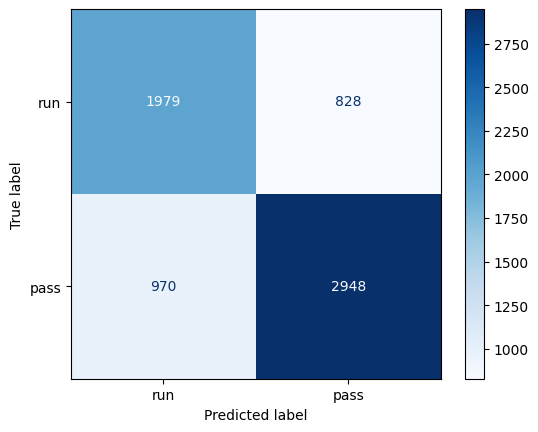

 
-------------------------------------------------------------------------------------------------------------------------------


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 400
max_resources_: 2000
aggressive_elimination: False
factor: 5.0
----------
iter: 0
n_candidates: 5
n_resources: 400
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 2000
Fitting 3 folds for each of 1 candidates, totalling 3 fits
--------------------------
 
ExtraTrees runtime: 110.0 minutes
ExtraTrees best training score: 0.735979455710615
ExtraTrees best test score: 0.7415613382899628
 
ExtraTrees parameters: {'clf__bootstrap': False, 'clf__ccp_alpha': 1.7009826850826932e-08, 'clf__criterion': 'entropy', 'clf__max_depth': 46, 'clf__max_features': 0.7586861415697828, 'clf__max_leaf_nodes': 49, 'clf__min_impurity_decrease': 1.320786777633551e-08, 'clf__min_samples_leaf': 0.003530704761003295, 'clf__min_samples_split

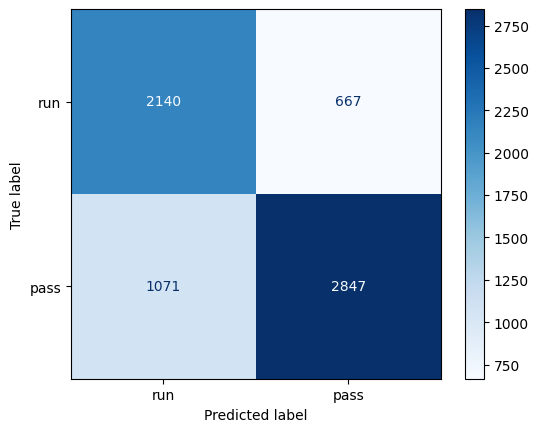

 
-------------------------------------------------------------------------------------------------------------------------------


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 400
max_resources_: 2000
aggressive_elimination: False
factor: 5.0
----------
iter: 0
n_candidates: 5
n_resources: 400
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 2000
Fitting 3 folds for each of 1 candidates, totalling 3 fits
--------------------------
 
GradientBoosting runtime: 98.0 minutes
GradientBoosting best training score: 0.737499622252577
GradientBoosting best test score: 0.737992565055762
 
GradientBoosting parameters: {'clf__ccp_alpha': 1.5503438071896285e-09, 'clf__criterion': 'friedman_mse', 'clf__learning_rate': 0.11901080861901027, 'clf__loss': 'exponential', 'clf__max_depth': 74, 'clf__max_features': 0.2376613493220846, 'clf__max_leaf_nodes': 73, 'clf__min_impurity_decrease': 3.9114181766447915e-

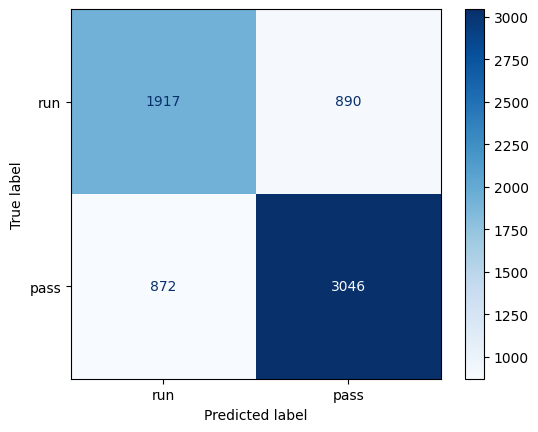

 
-------------------------------------------------------------------------------------------------------------------------------


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 400
max_resources_: 2000
aggressive_elimination: False
factor: 5.0
----------
iter: 0
n_candidates: 5
n_resources: 400
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 2000
Fitting 3 folds for each of 1 candidates, totalling 3 fits
--------------------------
 
AdaBoost runtime: 150.0 minutes
AdaBoost best training score: 0.7238838628125949
AdaBoost best test score: 0.7202973977695167
 
AdaBoost parameters: {'clf__algorithm': 'SAMME', 'clf__learning_rate': 0.0005553285954939532, 'clf__random_state': 67, 'ovr__n_neighbors': 3, 'pre__bin_transform__bin_discretizer__encode': 'ordinal', 'pre__bin_transform__bin_discretizer__n_bins': 6, 'pre__bin_transform__bin_discretizer__strategy': 'uniform', 'pre__bin_transform__bin_sca

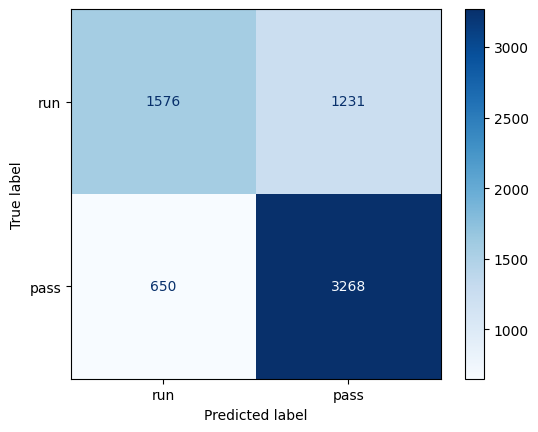

 
-------------------------------------------------------------------------------------------------------------------------------


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 400
max_resources_: 2000
aggressive_elimination: False
factor: 5.0
----------
iter: 0
n_candidates: 5
n_resources: 400
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 2000
Fitting 3 folds for each of 1 candidates, totalling 3 fits
--------------------------
 
XGBoost runtime: 130.0 minutes
XGBoost best training score: 0.7319476140742088
XGBoost best test score: 0.7418587360594796
 
XGBoost parameters: {'clf__booster': 'gbtree', 'clf__eta': 0.20607775341273496, 'clf__eval_metric': 'logloss', 'clf__grow_policy': 'depthwise', 'clf__max_bin': 256, 'clf__max_depth': 10, 'clf__objective': 'binary:hinge', 'clf__seed': 67, 'clf__tree_method': 'hist', 'ovr__n_neighbors': 3, 'pre__bin_transform__bin_discretizer__encode': 'ordi

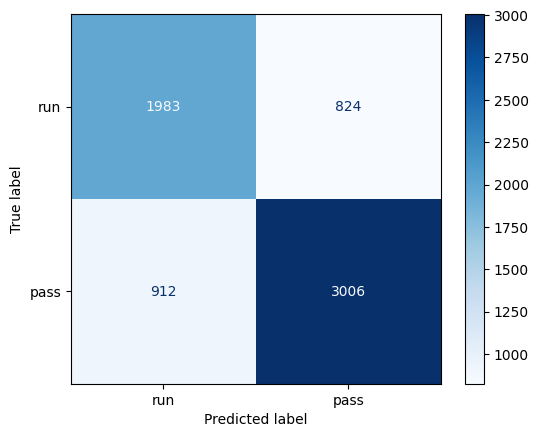

 
-------------------------------------------------------------------------------------------------------------------------------



In [16]:
# Define the models
models = [
    ('RandomForest', RandomForestClassifier()),
    ('ExtraTrees', ExtraTreesClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('XGBoost', XGBClassifier()),
]

# Create and run the pipeline
for model_name, model in models:
    pipeline = Pipeline([
        ('pre', preprocessing),
        ('sel', RFE(RandomForestClassifier(n_estimators=rfc_est, max_features=rfc_max, class_weight='balanced_subsample', n_jobs=6, random_state=67))),
        ('ovr', ADASYN(sampling_strategy='not majority', random_state=67)),
        ('clf', model)
    ])
 
    params = {}

    if model_name == 'RandomForest':
        params = {
            'pre__cat_transform__cat_encoder__sigma': loguniform(0.001, 0.05),
            'pre__num_transform__num_scaler': scaler_list,
            'pre__bin_transform__bin_discretizer__n_bins': randint(5, 15),
            'pre__bin_transform__bin_discretizer__strategy': bin_discretizer_strategy, 
            'pre__bin_transform__bin_discretizer__encode': bin_discretizer_encode,
            'pre__bin_transform__bin_scaler': scaler_list,
            'sel__n_features_to_select': randint(40, 85),
            'sel__step': [2],
            'ovr__n_neighbors': randint(2, 6),
            'clf__bootstrap': [True],
            'clf__ccp_alpha': loguniform(1e-05, 1e-00),                                   # Cost-complexity pruning is an algorithm used to prune a tree to avoid over-fitting
            'clf__criterion': ['gini'],
            'clf__max_depth': randint(50, 90),
            'clf__max_features': loguniform(0.40, 0.85), 
            'clf__min_impurity_decrease': loguniform(1e-10, 1e-06),
            #'clf__max_samples': loguniform(0.05, 0.40),                                  # Only for bootstrap=True. Including this parameter significantly reduced model performance. 
            'clf__min_samples_leaf': loguniform(0.05, 0.25),
            'clf__min_samples_split': loguniform(0.05, 0.25),
            'clf__min_weight_fraction_leaf': loguniform(0.05, 0.25),
            'clf__oob_score': [False],                                                    # Only for bootstrap=True
            'clf__warm_start': [True],
            'clf__n_jobs': [6],
            'clf__random_state': [67],
        }

    elif model_name == 'ExtraTrees':
        params = {
            'pre__cat_transform__cat_encoder__sigma': loguniform(0.001, 0.05),
            'pre__num_transform__num_scaler': scaler_list,
            'pre__bin_transform__bin_discretizer__n_bins': randint(5, 15),
            'pre__bin_transform__bin_discretizer__strategy': bin_discretizer_strategy, 
            'pre__bin_transform__bin_discretizer__encode': bin_discretizer_encode,
            'pre__bin_transform__bin_scaler': scaler_list,
            'sel__n_features_to_select': randint(35, 85),
            'sel__step': [2],
            'ovr__n_neighbors': randint(2, 6), 
            'clf__bootstrap': [False],
            'clf__ccp_alpha': loguniform(1e-08, 1e-03),                                   # Cost-complexity pruning is an algorithm used to prune a tree to avoid over-fitting
            'clf__criterion': ['entropy'],
            'clf__max_depth': randint(40, 90),
            'clf__max_features': loguniform(0.35, 0.85),
            'clf__max_leaf_nodes': randint(30, 85),
            #'clf__max_samples': loguniform(0.10, 0.50),                                  # Only for bootstrap=True
            'clf__min_impurity_decrease': loguniform(1e-10, 1e-07),
            'clf__min_samples_leaf': loguniform(0.001, 0.10),
            'clf__min_samples_split': loguniform(0.001, 0.10),
            'clf__min_weight_fraction_leaf': loguniform(0.001, 0.10),
            'clf__oob_score': [False],                                                    # Only for bootstrap=True
            'clf__warm_start': [False],
            'clf__n_jobs': [6],
            'clf__random_state': [67],
        }

    elif model_name == 'GradientBoosting':
        params = {
            'pre__cat_transform__cat_encoder__sigma': loguniform(0.001, 0.05),
            'pre__num_transform__num_scaler': scaler_list,
            'pre__bin_transform__bin_discretizer__n_bins': randint(5, 15),
            'pre__bin_transform__bin_discretizer__strategy': bin_discretizer_strategy, 
            'pre__bin_transform__bin_discretizer__encode': bin_discretizer_encode,
            'pre__bin_transform__bin_scaler': scaler_list,
            'sel__n_features_to_select': randint(30, 75),
            'sel__step': [2],
            'ovr__n_neighbors':randint(2, 6),
            'clf__criterion': ['friedman_mse'],
            'clf__ccp_alpha': loguniform(1e-10, 1e-06),                                   # Cost-complexity pruning is an algorithm used to prune a tree to avoid over-fitting
            'clf__learning_rate': loguniform(1e-03, 1e-00),
            'clf__loss': ['exponential'],
            'clf__max_depth': randint(30, 75),
            'clf__max_features': loguniform(0.15, 0.55), 
            'clf__max_leaf_nodes': randint(50, 80),
            'clf__min_weight_fraction_leaf': loguniform(0.30, 0.50),                      # Must be <= 0.5
            'clf__min_impurity_decrease': loguniform(1e-10, 1e-07),
            'clf__min_samples_leaf': loguniform(0.005, 0.15),
            'clf__min_samples_split': loguniform(0.02, 0.25),
            'clf__n_iter_no_change': [150],
            'clf__tol': loguniform(1e-10, 1e-06),
            'clf__validation_fraction': [0.10],
            'clf__warm_start': [True, False],
            'clf__subsample': loguniform(0.95, 1.0),
            'clf__random_state': [67],
        }

    elif model_name == 'AdaBoost':
        params = {
            'pre__cat_transform__cat_encoder__sigma': loguniform(0.001, 0.05),
            'pre__num_transform__num_scaler': scaler_list,
            'pre__bin_transform__bin_discretizer__n_bins': randint(5, 15),
            'pre__bin_transform__bin_discretizer__strategy': bin_discretizer_strategy, 
            'pre__bin_transform__bin_discretizer__encode': bin_discretizer_encode,
            'pre__bin_transform__bin_scaler': scaler_list,
            'sel__n_features_to_select': randint(5, 50),
            'sel__step': [2],
            'ovr__n_neighbors': randint(2, 6), 
            'clf__algorithm': ['SAMME'],
            'clf__learning_rate': loguniform(1e-04, 1e-00),
            'clf__random_state': [67],
        }

    elif model_name == 'XGBoost':
        params = {
            'pre__cat_transform__cat_encoder__sigma': loguniform(0.001, 0.05),
            'pre__num_transform__num_scaler': scaler_list,
            'pre__bin_transform__bin_discretizer__n_bins': randint(5, 15),
            'pre__bin_transform__bin_discretizer__strategy': bin_discretizer_strategy, 
            'pre__bin_transform__bin_discretizer__encode': bin_discretizer_encode,
            'pre__bin_transform__bin_scaler': scaler_list,
            'sel__n_features_to_select': randint(5, 50),
            'sel__step': [2],
            'ovr__n_neighbors': randint(2, 6), 
            'clf__tree_method': ['hist','auto'],                                                      # 'hist' is faster than 'auto'
            'clf__booster': ['gbtree'],                                                        # 'gbtree' is faster than 'gblinear'
            'clf__eta': loguniform(0.20, 0.40),
            'clf__max_depth': [10],
            'clf__max_bin': [256],
            'clf__grow_policy': ['depthwise','lossguide'],                                     # 'lossguide','depthwise'
            'clf__objective': ['binary:hinge'],
            'clf__eval_metric': ['logloss'],
            'clf__seed': [67],
        }
    
    search = HalvingRandomSearchCV(
        estimator=pipeline,
        param_distributions=params,
        scoring='accuracy',
        factor=halving_parameter,
        resource='clf__n_estimators',
        n_candidates='exhaust',
        min_resources=min_resource,
        max_resources=max_resource,
        aggressive_elimination=False,
        return_train_score=True,
        refit=True,
        cv=n_cross_validation,
        n_jobs=6,
        random_state=67,
        verbose=1,
        error_score='raise',
    )
    
    start_training_time = time.time()
    search.fit(X_train, y_train)
    
    # Print training and test results
    print('--------------------------')
    print(' ')
    end_training_time = time.time()
    print(f"{model_name} runtime:", round((end_training_time - start_training_time) / 60, 0), 'minutes')
    print(f"{model_name} best training score: {search.best_score_}")
    print(f"{model_name} best test score: {search.score(X_test, y_test)}")
    print(' ')
    print(f"{model_name} parameters: {search.best_params_}")
    print(' ')

    # Print features selected during recursive feature selection (RFE)
    selected_features = zip(search.best_estimator_.named_steps['sel'].ranking_, initial_features, search.best_estimator_.named_steps['sel'].support_)
    selected_features = [x for x in selected_features if x[2] == True]
    selected_features = [x[1] for x in selected_features]
    print(f"{model_name} features: {selected_features}")
    print(' ')
    
    # Print classification report and confusion matrix
    print(classification_report(y_test, search.predict(X_test), target_names=['run','pass'], digits=4))
    cm = confusion_matrix(y_test, search.predict(X_test))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['run','pass']).plot(cmap=plt.cm.Blues) 
    plt.show()
    
    # Save the best model, parameters, and features for each model, naming the file with the model name
    model_file = f'/Users/ttas2/Documents/Python/nfl-machine-learning-models/output_files/play_predictions/{model_name}_halving_random_search_cv_model.pkl'
    params_file = f'/Users/ttas2/Documents/Python/nfl-machine-learning-models/output_files/play_predictions/{model_name}_halving_random_search_cv_params.pkl'
    features_file = f'/Users/ttas2/Documents/Python/nfl-machine-learning-models/output_files/play_predictions/{model_name}_halving_random_search_cv_features.pkl'
    
    print(' ')
    print('-------------------------------------------------------------------------------------------------------------------------------')
    print("\n")


In [17]:
# Calculate workbook processing time in hours
end_time = time.time()
total_time = end_time - start_time

print('Total HalvingRandomSearchCV runtime', round(total_time / 3600, 2), 'hours')

Total HalvingRandomSearchCV runtime 9.57 hours
